In [1]:
import json
import re
import numpy as np
from itertools import combinations
import random as rd
from sklearn.utils import shuffle
from collections import defaultdict
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from hyperopt import hp, tpe, fmin, Trials, STATUS_OK
from tabulate import tabulate


<class 'dict'>
1262


In [3]:
# Load the JSON data file
with open('/content/TVs-all-merged.json') as f:
  data = json.load(f)

print(type(data))

print(data)
#print(data)

<class 'dict'>
{'29PFL4508/F7': [{'shop': 'bestbuy.com', 'url': 'http://www.bestbuy.com/site/Philips+-+4000+Series+-+29%26%2334%3B+Class+(28-1/2%26%2334%3B+Diag.)+-+LED+-+720p+-+60Hz+-+HDTV/9806538.p;template=_specificationsTab', 'modelID': '29PFL4508/F7', 'featuresMap': {'Screen Size Class': '29"', 'DVI Inputs': '0', 'ENERGY STAR Certified': 'Yes', 'Ethernet Port': 'No', 'Sleep Timer': 'Yes', 'Width': '27 inches', 'USB Port': 'Yes', 'TV Type': 'LED Flat-Panel', 'V-Chip': 'Yes', 'Component Video Inputs': '1', 'UPC': '609585230651', 'Screen Size (Measured Diagonally)': '28-1/2"', 'Mount Bracket/VESA Pattern': '100mm x 100mm', 'PC Inputs': '1', 'Aspect Ratio': '4:3 and 16:9', 'Audio Outputs': '1', 'Sound Leveler': 'Yes', 'Media Card Slot': 'No', 'Weight': '12.1 lbs. with stand (10.6 lbs. without)', 'Vertical Resolution': '720p', 'Composite Inputs': '1', 'Brightness': '270 cd/mÂ²', 'Watts/Channel': '8', 'HDMI Inputs': '3', 'Maximum Resolution': '1366 x 768', 'Screen Refresh Rate': '60Hz',

In [4]:
descriptions = {}
i = 1
for key in data.keys():
    for description in data[key]:
        descriptions[i] = description
        i+=1
print(len(descriptions.keys()))
print(descriptions)

1624
{1: {'shop': 'bestbuy.com', 'url': 'http://www.bestbuy.com/site/Philips+-+4000+Series+-+29%26%2334%3B+Class+(28-1/2%26%2334%3B+Diag.)+-+LED+-+720p+-+60Hz+-+HDTV/9806538.p;template=_specificationsTab', 'modelID': '29PFL4508/F7', 'featuresMap': {'Screen Size Class': '29"', 'DVI Inputs': '0', 'ENERGY STAR Certified': 'Yes', 'Ethernet Port': 'No', 'Sleep Timer': 'Yes', 'Width': '27 inches', 'USB Port': 'Yes', 'TV Type': 'LED Flat-Panel', 'V-Chip': 'Yes', 'Component Video Inputs': '1', 'UPC': '609585230651', 'Screen Size (Measured Diagonally)': '28-1/2"', 'Mount Bracket/VESA Pattern': '100mm x 100mm', 'PC Inputs': '1', 'Aspect Ratio': '4:3 and 16:9', 'Audio Outputs': '1', 'Sound Leveler': 'Yes', 'Media Card Slot': 'No', 'Weight': '12.1 lbs. with stand (10.6 lbs. without)', 'Vertical Resolution': '720p', 'Composite Inputs': '1', 'Brightness': '270 cd/mÂ²', 'Watts/Channel': '8', 'HDMI Inputs': '3', 'Maximum Resolution': '1366 x 768', 'Screen Refresh Rate': '60Hz', 'Product Height (with s

In [5]:
#preprocess the data

def preprocess_data(descriptions):
    titles=[]
    features=[]
    for d in descriptions:
        title = descriptions[d]['title'].lower()
        title = re.sub(r'\"|inches|-inches|-inch|-in|\\sin|in\$| inches', 'inch', title)
        title = re.sub(r'hertz|-hertz|-hz| hz\$| hertz| hz', 'hz', title)
        title = re.sub(r' pounds|pounds| lbs|lbs| lb|lbs.| lb.|lb.', 'lb', title)
        title = re.sub(r'(|)', '', title)

        titles.append(title)

        productFeatures = []
        for key in descriptions[d]['featuresMap'].keys():
            feature = descriptions[d]['featuresMap'][key].lower()
            feature = re.sub(r'\"|inches|-inches|-inch|-in|\\sin|in\$| inches', 'inch', feature)
            feature = re.sub(r'hertz|-hertz|-hz| hz\$| hertz| hz', 'hz', feature)
            feature = re.sub(r' pounds|pounds| lbs|lbs| lb|lbs.| lb.|lb.', 'lb', feature)
            feature = re.sub(r'(|)', '', feature)
            productFeatures.append(feature)

        features.append(productFeatures)

    return titles

#titles = preprocess_data(descriptions)
#print(titles)

#titles, features = preprocess_data(descriptions)
#print(len(titles))
#print(titles)

In [6]:

# Extract model words

def getModelWords(titles):#, features):
    modelWordsTitle = []
    modelWordsFeature = []
    pattern = r'[a-zA-Z]+[0-9]+[a-zA-Z0-9]*|[a-zA-Z0-9]*[0-9]+[a-zA-Z]+|[0-9]+[.][0-9]+[a-zA-Z]*'
    pattern2 = r'^\d+(\.\d+)?[a-zA-Z]+$|^\d+(\.\d+)?$'


    for title in titles:
        modelWordsTitle.extend(re.findall(pattern, title))

  #  for j in range(len(features)):
      #  modelWordsFeature.append(re.findall(pattern2, features[j]))
    # Merge the two lists
    #merged_list = modelWordsTitle + modelWordsFeature

    # Extract unique model words and sort them
    ModelWords = set(modelWordsTitle)


    return ModelWords  #, modelWordsFeature#, merged_list

#modelwords = getModelWords(titles)
##print(modelwords)
#print(len(modelwords))


In [7]:
def getBinaryMatrix(titles, model_words):
    # Initialize the binary matrix
    binary_matrix = np.zeros((len(model_words), len(titles)), dtype=int)

    # Iterate over model words
    for i, mw in enumerate(model_words):
        # Iterate over titles
        for j, title in enumerate(titles):
            # Check if the title contains the model word
            if mw in title:
                binary_matrix[i, j] = 1

    return binary_matrix




#binarymatrix = getBinaryMatrix(titles, modelwords)


In [8]:
# Minhash

def minhash(binary_matrix, num_hashes):
    num_rows, num_cols = binary_matrix.shape

    # Initialize the signature matrix with infinity values
    signature_matrix = np.full((num_hashes, num_cols), np.inf)

    # Generate hash functions
    hash_functions = [hash_function(i) for i in range(num_hashes)]

    # Apply minhashing
    for row in range(num_rows):
        for col in range(num_cols):
            if binary_matrix[row, col] == 1:
                for i in range(num_hashes):
                    # Update the signature matrix
                    signature_matrix[i, col] = min(signature_matrix[i, col], hash_functions[i](row))

    return signature_matrix

def hash_function(seed):
    # hash func
    def hash_value(x):
        return (x ^ seed) % 1000  # 1000 is an arbitrary large prime number
    return hash_value

#num_hashes = 200
#signature_matrix = minhash(binarymatrix, num_hashes)
#print(signature_matrix)

In [9]:
#LSH
def LSH(signature_matrix, numbands, data):



  signature_matrix = signature_matrix.astype(int)

  #Locality-Sensitive Hashing
  buckets = defaultdict(set)
  bands = np.array_split(signature_matrix, numbands, axis=0)

  for i, band in enumerate(bands):
    for j in range(signature_matrix.shape[1]):
      band_id = tuple(list(band[:,j])+[str(i)])
      buckets[band_id].add(j)

  candidates_duplicates = set()
  #print("no buckets: "+ str(len(buckets)))


  for bucket in buckets.values():
    if len(bucket) > 1:
      for pair in combinations(bucket,2):
        candidates_duplicates.add(pair)

  dissimilarities = np.full((signature_matrix.shape[1],signature_matrix.shape[1]), -1*np.inf)
  unique_candidates = candidates_duplicates


  remove_set = set()
  for i in unique_candidates:
    item_1 = i[0]
    item_2 = i[1]
    if dissimilarities[item_1][item_2] == 1:
      remove_set.add(i)
    dissimilarities[item_1][item_2] = 1
    dissimilarities[item_2][item_1] = 1

  #print("candidates: " +str(len(unique_candidates)))
  #remove duplicates
  for i in remove_set:
    unique_candidates.remove(i)

  candidate_pairs = []

  for i in unique_candidates:
    item_1 = i[0]
    item_2 = i[1]
    candidate_pairs.append((item_1,item_2))

  return candidate_pairs
#candidatepairs = LSH(signature_matrix,6, descriptions)

In [ ]:
print(len(candidatepairs))

53087


In [10]:
#q-grams

#calculating dice coefficients for q-grams
def dice_coefficient(a, b, q):
  """dice coefficient 2nt/(na + nb)."""
  if not len(a) or not len(b): return 0.0
  #if shorter than 3(q), append something that doesnt occur after cleaning
  while len(a) < q:
    if len(a) == 1:  a=a+u'@'
    if len(a) == 2:  a=a+u'?'
    if len(a) == 3:  a=a+u'#'
    if len(a) == 4:  a=a+u')'

  while len(b) < q:
    if len(b) == 1:  b=b+u'$'
    if len(b) == 2:  b=b+u'&'
    if len(b) == 3:  b=b+u'%'
    if len(b) == 4:  b=b+u'('

  a_bigram_list=[]
  for i in range(len(a)-(q-1)):
    a_bigram_list.append(a[i:i+q])

  b_bigram_list=[]
  for i in range(len(b)-(q-1)):
    b_bigram_list.append(b[i:i+q])

  a_bigrams = set(a_bigram_list)
  b_bigrams = set(b_bigram_list)
  overlap = len(a_bigrams & b_bigrams)

  dice_coeff = overlap * 2.0/(len(a_bigrams) + len(b_bigrams))
  return dice_coeff

#----------------------------------------------------------------------
#q-gram similarity measure between two candidates
def similarity_qgram(title_a, title_b, q):


  titleSim = dice_coefficient(str(title_a).replace(" ",""),str(title_b).replace(" ",""),q)


  return titleSim

#candidatetest = candidates[1]
#titlrim = similarity_qgram(descriptions[candidatetest[0]]['title'], descriptions[candidatetest[1]]['title'],5,)
#print(titlrim)

In [11]:
brands = []
for d in descriptions:
      for key in descriptions[d]['featuresMap'].keys():
        # Check if 'featuresMap' key exists and is a dictionary
            featuremap = descriptions[d]['featuresMap'][key].lower()
            # Check if 'Brand' key exists in featuresMap
            if key == 'Brand':
                brand_value = descriptions[d]['featuresMap'][key].lower()
                if brand_value not in brands:
                    brands.append(brand_value)
            # Check if 'Brand Name' key exists in featuresMap
            elif 'Brand Name' in featuremap:
                brand_value = featuremap['Brand Name'].lower()
                if brand_value not in brands:
                    brands.append(brand_value)

# Now 'brands' should contain unique lowercase brand names

#print(brands)

In [12]:
#goede versie
def finalcandidates(candidates, beta, brands, items, q, alpha):
  finalcandidates = []

  for pair in candidates:
    index_1, index_2 = pair
    item_1 = items[index_1+1]
    item_2 = items[index_2+1]

    brand_1 = ''
    brand_1_found = False
    brand_2 = ''
    brand_2_found = False

    # Retrieving brands of the index
    for brand in brands:
        if brand in item_1['title'].lower():
            brand_1 = brand
            brand_1_found = True
        if brand in item_2['title'].lower():
            brand_2 = brand
            brand_2_found = True

    if  (brand_1 == brand_2) or not brand_1_found or not brand_2_found:
        # If the brands are different and both are found, add to finalcandidates
        finalcandidates.append(pair)
    #elif items[pair[0]+1]['shop'] == items[pair[1]+1]['shop']: #assuming the same shop doesn't list the same item twice, remove if same shop
     #   finalcandidates.remove(pair)

   #as now all remaining candidates and have same brand, dont pay attention to this for similarity
  for pair in finalcandidates:
    for i in pair:
        if any(word in brands for word in items[i+1]['title']):
          items[i+1]['title'].replace(word,"")

  #duplicate detection using q-grams in MSM
  sim_dupl = []
  sim_non_dupl = []
  #print("Remaining pre q-gram: " + str(len(duplicates)))
  count = 0

  for pair in finalcandidates.copy():
    similarityscore_qgram = similarity_qgram(items[pair[0]+1]['title'],items[pair[1]+1]['title'], q)
    similarityscore_jaccard = jaccard_similarity(items[pair[0]+1]['title'],items[pair[1]+1]['title'])
    similarity = alpha * similarityscore_qgram + (1 - alpha) * similarityscore_jaccard
    if similarity < beta:
      finalcandidates.remove(pair)
      count+=1

    if items[pair[0]+1]['modelID'] == items[pair[1]+1]['modelID']:
      sim_dupl.append(similarity)
    else:
      sim_non_dupl.append(similarity)

  return finalcandidates

#finalcandidates = finalcandidates(candidatepairs,0.5,brands,descriptions, 5)


In [24]:

def jaccard_similarity(set1, set2):
    intersection = len(set(set1).intersection(set(set2)))
    union = len(set(set1).union(set(set2)))
    similarity = intersection / union if union != 0 else 0
    return similarity

def compute_jaccard_similarities(candidate_list, data):
    jaccard_similarities = []
    threshold = 0.6

    for candidate in candidate_list:
        index1, index2 = candidate
        try:
            set1 = set(data[index1 + 1]['featuresMap'].keys())
            set2 = set(data[index2 + 1]['featuresMap'].keys())
            similarity = jaccard_similarity(set1, set2)

            if similarity > threshold:
                jaccard_similarities.append((index1, index2))
        except KeyError as e:
            print(f"KeyError: {e} for candidate: {candidate}")

    return jaccard_similarities


def allDuplicates(data):
    """Returns a list of pairs of indices for actual positive instances in the data"""
    modelIDs = {}
    actual_positives = []

    for key, instance in data.items():
        current_model_id = instance['modelID']

        if current_model_id in modelIDs:
            # If we've seen this modelID before, add the current pair to actual positive pairs
            actual_positives.append((modelIDs[current_model_id], key))
        else:
            # First occurrence of this modelID, just store the current key
            modelIDs[current_model_id] = key

        allduplicates = list(actual_positives)
        numduplicates = len(allduplicates)
    return allduplicates, numduplicates


def truePositive(candidate_pairs, data, pairs, numduplicates):
    TP = 0
    for cand in range(len(pairs)):
      if data[pairs[cand][0]+1]['modelID'] == data[pairs[cand][1]+1]['modelID']:
         TP += 1

    FP = len(pairs) - TP
    FN = numduplicates - TP
    return TP, FP, FN
#jaccardpairs = compute_jaccard_similarities(candidates, descriptions)#,10, 6)
#allduplicates, numduplicates = allDuplicates(descriptions)
#print(numduplicates)
#result = truePositive(candidatepairs, descriptions, finalcandidates, numduplicates)
#print(result)

In [14]:
def getMetrics(candidates, allduplicates, numduplicates, finalcandidates, TP, FN):
    #metrics
    Df = len(list(set(finalcandidates).intersection(allduplicates)))
    PQ = Df/len(finalcandidates)
    PC = Df / numduplicates

    if (PQ+PC) != 0:
        F1_star = (2 * PQ * PC)/ (PQ+PC)
    else: F1_star = 0
    precision = TP / len(finalcandidates)
    recall = TP / (TP + FN)
    F1 = (2 * recall * precision ) / (recall + precision)
    return PQ, PC, F1_star, precision, recall, F1, Df

#metrics = getMetrics(candidatepairs, allduplicates, numduplicates, jaccardpairs, TP, FN)
#print(metrics)

In [15]:
def splitdata(data, n_samples, iter):
  """Samples data
  param: data, dictionary with all product information, dictionary
  param: n_samples, number of samples to draw, integer
  """
  traindata = {}
  np.random.seed(iter)
  for i in range(1, n_samples+1):
    randomindex = random.randint(1,len(data))
    traindata[i] = data[randomindex]
  return traindata

#traindata = splitdata(descriptions, int(len(descriptions)*0.6))
#print(traindata)

In [16]:
def bootstrap_and_split(data, iter, train_size=0.63):
    # Generate indices for bootstrap sampling
    num_samples = len(data)
    np.random.seed(iter)

    traindata = {}
    n_trainsample = int(train_size*len(data))
    for i in range(1, n_trainsample+1):
      randomindex = random.randint(1,len(data))
      traindata[i] = data[randomindex]

    testdata = {}
    n_testsample = int((1-train_size)*len(data))
    for i in range(1, n_testsample+1):
      randomindex = random.randint(1,len(data))
      testdata[i] = data[randomindex]

    return traindata, testdata


In [50]:
#Bootstrap
#5 bootstraps
#Bootstraps for LSH performance
bootstraps = 5
iter = 0
bandsrows =[]
T = []

beta = 0.4
alpha = 0.35

numhash = 600 #number of hash functions


for r in [ 10, 15, 24, 40, 60, 100, 120, 150]: #Manually configured based on threshold values
    if (numhash % r) == 0:
        b = numhash/ r
        t = (1/b) ** (1/r)
        bandsrows.append([t,b,r])
        T.append(t)


q = 4

while iter != bootstraps:
    #Sample data
    data = splitdata(descriptions, int(len(descriptions)*0.63),iter)

    #Create titles
    titles = preprocess_data(data)
    modelwords = getModelWords(titles)

    #Start minhasing
    binary_matrix = getBinaryMatrix(titles, modelwords)
    signatures = minhash(binary_matrix, numhash)
    #

    #

    #Metric values for all band values for bootstrap i
    PQ_i  = []
    PC_i = []
    F1star_i = []
    F1_i = []
    #Precision_i = []
   # Recall_i = []
   # Df_i = []
    foc_i = []

    for bandrow in bandsrows:
        #Apply LSH
        bands =  int(bandrow[1])
        candidates = LSH(signatures, bands, data)

        #Apply q grams
        final_candidates  = finalcandidates(candidates, beta, brands, data, q, alpha)

        #Compute measures
        allduplicates, numduplicates = allDuplicates(data)
        TP, FP, FN = truePositive(candidates, data, final_candidates, numduplicates)
        PQ, PC, F1_star, precision, recall, F1, Df = getMetrics(candidates, allduplicates, numduplicates, final_candidates, TP, FN)
        num_keys = len(data.keys())
        total_possible_comparisons = num_keys * (num_keys - 1) // 2  # Using the formula for combinations
        fraction_of_comparison = len(candidates) / total_possible_comparisons

        PQ_i.append(PQ)
        PC_i.append(PC)
        F1star_i.append(F1_star)
        F1_i.append(F1)
       # Precision_i.append(precision)
       # Recall_i.append(recall)
       # Df_i.append(Df)
        foc_i.append(fraction_of_comparison)

    if iter==0:
        measures = np.stack((PQ_i, PC_i, F1star_i, F1_i, foc_i),0)#, Precision_i, Recall_i, Df_i ), 0) #foc_i
    else:
        measures += np.stack((PQ_i, PC_i, F1star_i, F1_i, foc_i ), 0) #foc_i

    iter += 1

#averaged measures with rows=(PQ, PC, F1star, F1) and columns=|settings|
av_measures = measures / bootstraps
print('\n PQ:', av_measures[0], '\n PC:', av_measures[1], '\n F1_star', av_measures[2], '\n F1', av_measures[3],'\n fraction_of_comparisons', av_measures[4])#,'\n Precision', av_measures[5], '\n Recall', av_measures[6], '\n Df', av_measures[7])  #






 PQ: [0.00057988 0.00059079 0.0005976  0.00065132 0.00045446 0.00038157
 0.00030719 0.00036235] 
 PC: [0.07652015 0.07311828 0.07198834 0.04965864 0.01827168 0.00967857
 0.00681599 0.00341779] 
 F1_star [0.00115101 0.00117208 0.00118533 0.00128569 0.0008868  0.00073417
 0.00058786 0.00065517] 
 F1 [0.02023126 0.02150505 0.02207365 0.03490304 0.06393547 0.09708233
 0.1092707  0.23127372] 
 fraction_of_comparisons [0.56061582 0.51935656 0.50180869 0.29564441 0.13745842 0.08273047
 0.07108634 0.02234822]


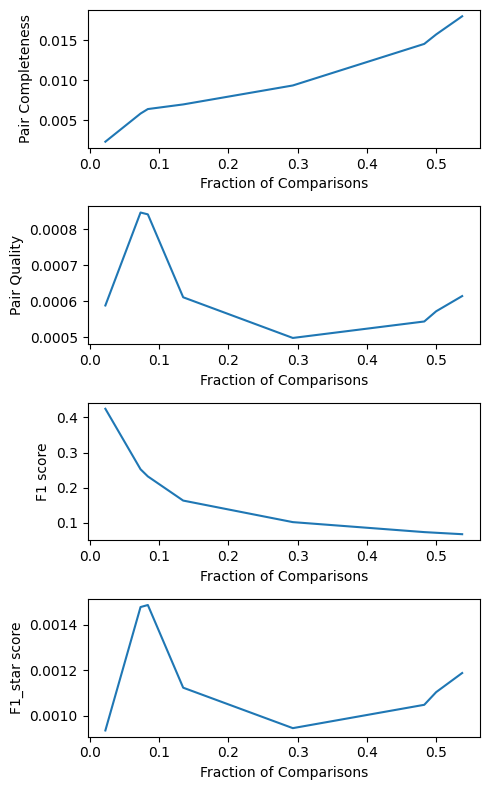

In [49]:
x = av_measures[4]
y_pc = av_measures[1]
y_pq = av_measures[0]
y_f1 = av_measures[3]
y_f1star = av_measures[2]


# Create subplots with 3 rows and 1 column
fig, axs = plt.subplots(4, 1, figsize=(5, 8))

# Plot Pair Completeness
axs[0].plot(x, y_pc)
axs[0].set_xlabel("Fraction of Comparisons")
axs[0].set_ylabel("Pair Completeness")

# Plot Pair Quality
axs[1].plot(x, y_pq)
axs[1].set_xlabel("Fraction of Comparisons")
axs[1].set_ylabel("Pair Quality")

# Plot F1 score
axs[2].plot(x, y_f1)
axs[2].set_xlabel("Fraction of Comparisons")
axs[2].set_ylabel("F1 score")

# Plot F1star score
axs[3].plot(x, y_f1star)
axs[3].set_xlabel("Fraction of Comparisons")
axs[3].set_ylabel("F1_star score")

plt.tight_layout()  # Adjust layout to prevent overlapping
plt.show()

In [22]:
def class_qgram_hyperopt(space, candidates, items,
                              brands=brands):

    beta = space['beta']
    q = space['q']
    alpha = space['alpha']

    final_candidates = []

    for pair in candidates:
      index_1, index_2 = pair
      item_1 = items[index_1+1]
      item_2 = items[index_2+1]

      brand_1 = ''
      brand_1_found = False
      brand_2 = ''
      brand_2_found = False

      # Retrieving brands of the index
      for brand in brands:
          if brand in item_1['title'].lower():
              brand_1 = brand
              brand_1_found = True
          if brand in item_2['title'].lower():
              brand_2 = brand
              brand_2_found = True

      if  (brand_1 == brand_2) or not brand_1_found or not brand_2_found:
          # If the brands are different and both are found, add to finalcandidates
          final_candidates.append(pair)
      #elif items[pair[0]+1]['shop'] == items[pair[1]+1]['shop']: #assuming the same shop doesn't list the same item twice, remove if same shop
      #   finalcandidates.remove(pair)

    #as now all remaining candidates and have same brand, dont pay attention to this for similarity
    for pair in final_candidates:
      for i in pair:
          if any(word in brands for word in items[i+1]['title']):
            items[i+1]['title'].replace(word,"")

    #duplicate detection using q-grams in MSM
    sim_dupl = []
    sim_non_dupl = []
    #print("Remaining pre q-gram: " + str(len(duplicates)))
    count = 0

    for pair in final_candidates:
      similarityscore_qgram = similarity_qgram(items[pair[0]+1]['title'],items[pair[1]+1]['title'], q)
      similarityscore_jaccard = jaccard_similarity(items[pair[0]+1]['title'],items[pair[1]+1]['title'])
      similarity = alpha * similarityscore_qgram + (1 - alpha) * similarityscore_jaccard
      if similarity < beta:
        final_candidates.remove(pair)
        count+=1

      if items[pair[0]+1]['modelID'] == items[pair[1]+1]['modelID']:
        sim_dupl.append(similarity)
      else:
        sim_non_dupl.append(similarity)

    #Compute measures
    allduplicates, numduplicates = allDuplicates(items)
    TP, FP, FN = truePositive(candidates, items, final_candidates, numduplicates)
    PQ, PC, F1_star, precision, recall, F1, Df = getMetrics(candidates, allduplicates, numduplicates, final_candidates, TP, FN)
    print('\n beta', beta, '\n q',q)
    return -1*F1

In [29]:
#Hyperparameter tuning

hyper_params_space = {
    'beta': hp.uniform('beta',0.5,0.8),
    'q': hp.randint('q', 3) + 3,
    'alpha': hp.uniform('alpha', 0.1,0.9)
    }

#Bootstrap
#5 bootstraps
#Bootstraps for LSH performance
bootstraps = 5
iter = 0
bandsrows =[]

numhash = 600 #number of hash functions


for r in [ 10, 12, 15, 20, 24, 30, 40, 48, 60, 80, 100, 120, 150]: #Manually configured based on threshold values.  1, 2, 3, 4, 5, 6, 8
    if (numhash % r) == 0:
        b = numhash/ r
        t = (1/b) ** (1/r)
        bandsrows.append([t,b,r])


result = np.zeros((13,len(bandsrows)))
band_iter = 0
bestf1score = -1
best_bands = None

#Iterate over all possible values for bands
for bandrow in bandsrows:
  bands =  int(bandrow[1])
  iter = 0

  #Metric values for all band values for number of bands
  PQ_pre_result  = []
  PC_pre_result = []
  F1_star_pre_result = []
  F1_pre_result = []
  PQ_result  = []
  PC_result = []
  F1_star_result = []
  F1_result = []
  FC_result = []
  beta_result = []
  alpha_result = []
  q_result = []
  #Precision_i = []
  # Recall_i = []
  # Df_i = []
  foc_i = []

  while iter != bootstraps:
    print("Starting bootstrap " + str(iter) + " with " + str(bands) + " bands.")
    #Sample data
    traindata, testdata = bootstrap_and_split(descriptions, iter)

    #Create titles
    titles_train = preprocess_data(traindata)
    modelwords_train = getModelWords(titles_train)

    #Start minhasing
    binary_matrix_train = getBinaryMatrix(titles_train, modelwords_train)
    signatures_train = minhash(binary_matrix_train, numhash)

    #Apply LSH
    candidates_train = LSH(signatures_train, bands, traindata)

    #Apply q grams
    #final_candidates_train  = finalcandidates(candidates_train, beta, brands, traindata, q)

    #Compute measures for train data
    allduplicates_train, numduplicates_train = allDuplicates(traindata)
    TP_train, FP_train, FN_train = truePositive(candidates_train, traindata, candidates_train, numduplicates_train)
    PQ_pre, PC_pre, F1_star_pre, precision_pre, recall_train, F1_pre, Df_train = getMetrics(candidates_train, allduplicates_train, numduplicates_train, candidates_train, TP_train, FN_train)
    num_keys_train = len(traindata.keys())
    total_possible_comparisons_train = num_keys_train * (num_keys_train - 1) // 2  # Using the formula for combinations
    fraction_of_comparison_train = len(candidates_train) / total_possible_comparisons_train

    PQ_pre_result = np.append(PQ_pre_result,PQ_pre)
    PC_pre_result = np.append(PC_pre_result,PC_pre)
    F1_star_pre_result = np.append(F1_star_pre_result,F1_star_pre)
    F1_pre_result = np.append(F1_pre_result,F1_pre,)
    # Precision_i.append(precision)
    # Recall_i.append(recall)
    # Df_i.append(Df)
    #foc_i.append(fraction_of_comparison)

    #if iter==0:
     #   measures_train = np.stack((PQ_i, PC_i, F1star_i, F1_i, foc_i),0)#, Precision_i, Recall_i, Df_i ), 0) #foc_i
    #else:
     #   measures_train += np.stack((PQ_i, PC_i, F1star_i, F1_i, foc_i ), 0) #foc_i


    #run hyperparameter optimization using the train set
    trials = Trials()
    optimal_hyperparams = fmin(fn=lambda params: class_qgram_hyperopt(params, candidates_train, traindata),
                          space=hyper_params_space,
                          algo=tpe.suggest,
                          max_evals=5,
                          trials=trials,
                               )

    #Create titles
    titles_test = preprocess_data(testdata)
    modelwords_test = getModelWords(titles_test)

    #Start minhasing
    binary_matrix_test = getBinaryMatrix(titles_test, modelwords_test)
    signatures_test = minhash(binary_matrix_test, numhash)

    #Apply LSH on test set
    candidates_test = LSH(signatures_test, bands, testdata)

    N_c_LSH = len(candidates_test)
    #final predictions on test set with optimal hyperparameters
    final_candidates_test  = finalcandidates(candidates_test, optimal_hyperparams['beta'], brands, testdata, optimal_hyperparams['q'], optimal_hyperparams['alpha'])
    #predicted_test_duplicates = final_classification_qgram(test_candidates, test_representation_hyperopt,3 ,optimal_hyperparams['alpha'],optimal_hyperparams['beta'],optimal_hyperparams['gamma'])
    N_c_final = len(final_candidates_test)

    #Compute measures for test data
    allduplicates_test, numduplicates_test = allDuplicates(testdata)
    TP_test, FP_test, FN_test = truePositive(candidates_test, testdata, final_candidates_test, numduplicates_test)
    PQ_test, PC_test, F1_star_test, precision_test, recall_test, F1_test, Df_test = getMetrics(candidates_test, allduplicates_test, numduplicates_test, final_candidates_test, TP_test, FN_test)
    num_keys_test = len(testdata.keys())
    total_possible_comparisons_test = num_keys_test * (num_keys_test - 1) // 2  # Using the formula for combinations
    fraction_of_comparison_test = len(candidates_test) / total_possible_comparisons_test

    PQ_result = np.append(PQ_result, PQ_test)
    PC_result = np.append(PC_result, PC_test)
    F1_result = np.append(F1_result, F1_test)
    F1_star_result = np.append(F1_star_result, F1_star_test)
    FC_result = np.append(FC_result, fraction_of_comparison_test)
    beta_result = np.append(beta_result, optimal_hyperparams['beta'])
    alpha_result = np.append(alpha_result, optimal_hyperparams['alpha'])
    q_result = np.append(q_result, optimal_hyperparams['q'])



    iter += 1
  print("FINISHED ITERATING FOR " + str(bands) + " BANDS ")


  result[0,band_iter] = bands
  result[1,band_iter] = np.mean(F1_pre_result)
  result[2,band_iter] = np.mean(F1_star_pre_result)
  result[3,band_iter] = np.mean(PQ_pre_result)
  result[4,band_iter] = np.mean(PC_pre_result)
  result[5,band_iter] = np.mean(F1_result)
  result[6,band_iter] = np.mean(F1_star_result)
  result[7,band_iter] = np.mean(PQ_result)
  result[8,band_iter] = np.mean(PC_result)
  result[9,band_iter] = np.mean(FC_result)
  result[10,band_iter] = np.mean(alpha_result)
  result[11,band_iter] = np.mean(beta_result)
  result[12,band_iter] = int(np.mean(q_result))



  if np.mean(F1_result) > bestf1score:
    bestf1score = np.mean(F1_result)
    best_bands = result[:,band_iter].copy()

  band_iter+=1

print("DONE")


if best_bands is not None:
    print('\n Best number of bands:', best_bands[0], '\n Average F1 measure:', best_bands[5], '\n Average F1-star measure:', best_bands[6], '\nAverage Pair Quality:', best_bands[7], '\n Average Pair Completeness:', best_bands[8], '\n Average FC result:', best_bands[9])
else:
    print("No bands found that satisfy the condition")


Starting bootstrap 0 with 60 bands.

 beta
0.7598621514864707

 q
4

 beta
0.6486352202332459

 q
4

 beta
0.5460427460334186

 q
5

 beta
0.7425505404469177

 q
3

 beta
0.592401041073254

 q
4
100%|██████████| 5/5 [04:04<00:00, 48.90s/trial, best loss: -0.02272470959738356]
Starting bootstrap 1 with 60 bands.

 beta
0.5413464373510034

 q
5

 beta
0.5838318069838941

 q
4

 beta
0.6842585838758026

 q
4

 beta
0.5929593434376819

 q
4

 beta
0.7466010485636526

 q
4
100%|██████████| 5/5 [04:38<00:00, 55.71s/trial, best loss: -0.02085735247877581]
Starting bootstrap 2 with 60 bands.

 beta
0.5271159303681873

 q
4

 beta
0.6333674509306786

 q
4

 beta
0.5803040825484087

 q
3

 beta
0.7961362984971613

 q
4

 beta
0.6990178760210788

 q
5
100%|██████████| 5/5 [04:03<00:00, 48.72s/trial, best loss: -0.023223023969478312]
Starting bootstrap 3 with 60 bands.

 beta
0.5619821615674747

 q
5

 beta
0.7665534934222644

 q
4

 beta
0.5463978020121134

 q
3

 beta
0.5043195913994621

 q
4

 

In [30]:
print(result)

[[6.00000000e+01 5.00000000e+01 4.00000000e+01 3.00000000e+01
  2.50000000e+01 2.00000000e+01 1.50000000e+01 1.00000000e+01
  6.00000000e+00 5.00000000e+00 4.00000000e+00]
 [3.29917203e-03 3.24610371e-03 3.63544773e-03 3.69945040e-03
  3.58297079e-03 5.86305516e-03 6.67467584e-03 1.29366505e-02
  2.10830245e-02 2.27945861e-02 6.84662328e-02]
 [1.14404700e-03 1.07005266e-03 1.02271729e-03 1.13646373e-03
  1.21866354e-03 1.12760519e-03 1.06655762e-03 8.14425344e-04
  8.53589632e-04 9.00065580e-04 5.73289422e-04]
 [5.72718618e-04 5.35673603e-04 5.12031439e-04 5.69001653e-04
  6.10147374e-04 5.64991399e-04 5.34590723e-04 4.09200781e-04
  4.30372495e-04 4.54126266e-04 2.95414142e-04]
 [4.71805540e-01 4.43279267e-01 3.89554980e-01 4.21270814e-01
  4.59214147e-01 2.68011819e-01 2.18997203e-01 8.38743441e-02
  5.15040067e-02 5.03202279e-02 9.78273322e-03]
 [5.77335439e-02 5.73239789e-02 6.64695867e-02 3.02497179e-02
  1.00954911e-01 8.28064613e-02 1.12936459e-01 1.91555776e-01
  2.22276576e-01

In [31]:

# Create table of the result
table_data = [
    ["bands"] + result[0,].tolist(),
    ["F1_pre"] + result[1,].tolist(),
    ["F1_star_pre"] + result[2,].tolist(),
    ["PQ_pre"] + result[3,].tolist(),
    ["PC_pre"] + result[4,].tolist(),
    ["F1"] + result[5,].tolist(),
    ["F1_star"] + result[6,].tolist(),
    ["PQ"] + result[7,].tolist(),
    ["PC"] + result[8,].tolist(),
    ["FOC"] + result[9,].tolist(),
    ["alpha"] + result[10,].tolist(),
    ["beta"] + result[11,].tolist(),
    ["alpha"] + result[12,].tolist(),
]

# Displaying the table
print(tabulate(table_data, headers="firstrow", tablefmt="fancy_grid"))
print(optimal_hyperparams)

╒═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╤═════════════╕
│ bands       │        60.0 │        50.0 │        40.0 │        30.0 │        25.0 │        20.0 │        15.0 │        10.0 │         6.0 │         5.0 │         4.0 │
╞═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╪═════════════╡
│ F1_pre      │ 0.00329917  │ 0.0032461   │ 0.00363545  │ 0.00369945  │ 0.00358297  │ 0.00586306  │ 0.00667468  │ 0.0129367   │ 0.021083    │ 0.0227946   │ 0.0684662   │
├─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┼─────────────┤
│ F1_star_pre │ 0.00114405  │ 0.00107005  │ 0.00102272  │ 0.00113646  │ 0.00121866  │ 0.00112761  │ 0.00106656  │ 0.000814425 │ 0.00085359  │ 0.000900

Text(0, 0.5, 'Pair Completeness')

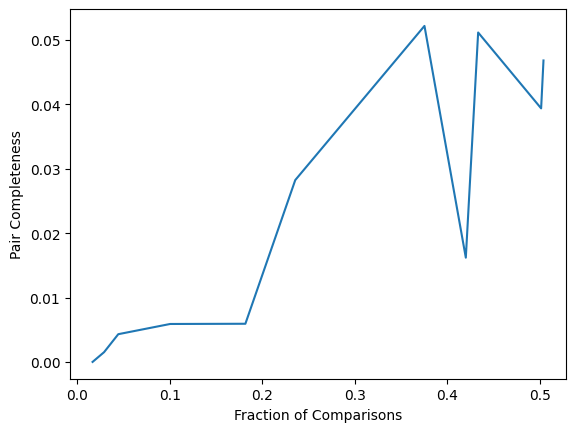

In [34]:
# Get the index that would sort the FC row in ascending order
sorted_indices = np.argsort(result[9, :])

# Sort the entire array based on the indices
result_sorted = result[:, sorted_indices]
x = result_sorted[9,:]
y_pc = result_sorted[8,:]
y_pq = result_sorted[7,:]
y_f1 = result_sorted[5,:]
plt.plot(x, y_pc)
#plt.plot(x, y_pq)
#plt.plot(x, y_f1)

plt.xlabel("Fraction of Comparisons")
plt.ylabel("Pair Completeness")
#plt.ylabel("Pair Quality")
#plt.ylabel("F1 score")
